<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel), and Mikhail Korshchikov (@MS4). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #3. Spring 2019
## <center> Part 1. Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/video](https://mlcourse.ai/video) 

### Your task is to:
 1. write code and perform computations in the cells below
 2. choose answers in the [webform](https://docs.google.com/forms/d/1UupRN8TS7C9-lfD7OlgJzmD0ZfNe1dKUSLLaTnUokMw/edit). Solutions will be shared only with those who've filled in this form 
 
### <center> Deadline for A3: 2019 March 31, 20:59 GMT (London time)

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Decision trees for regression: a toy example

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

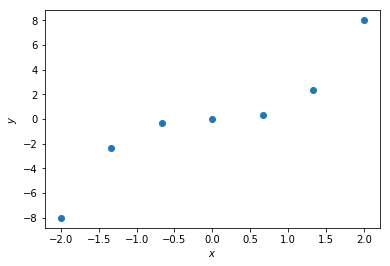

In [5]:
X = np.linspace(-2, 2, 7)
y = X ** 3 # original dependecy 

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the leaf returns the average value for all observations in this leaf.

Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>You'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> Create an appropriate plot using a pen, paper and Python if needed (but no `sklearn` is needed yet).

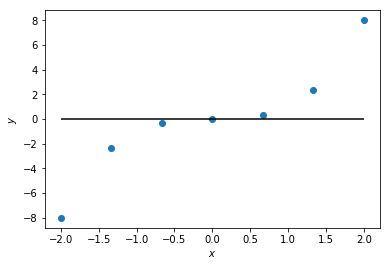

In [6]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.hlines(np.mean(y), -2, 2);

**Making first splits.**
<br>Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value. Let's create a similar plot for predictions of this tree.

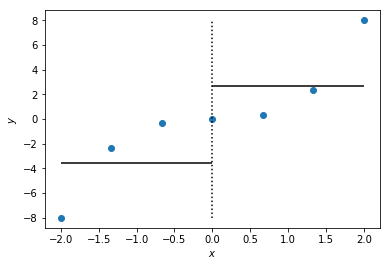

In [7]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.hlines(np.mean(y[X < 0]), -2, 0)
plt.hlines(np.mean(y[X >= 0]), 0, 2)
plt.vlines(0, -8, 8, 'k', 'dotted');

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance: $$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$
where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:
$$\large D(X) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$
Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 0$.

In [8]:
np.var(y)

19.916127767979617

In [9]:
1/len(y) * np.sum(np.square(y - np.mean(y)))

19.916127767979617

In [10]:
def regression_var_criterion(X, y, t):
    D_X = np.var(y)
    Q = D_X - (X[X < t].shape[0] / X.shape[0]) * np.var(y[X < t]) - (X[X >= t].shape[0] / X.shape[0]) * np.var(y[X >= t])
    return Q

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

In [11]:
Qs = [regression_var_criterion(X, y, t) for t in np.arange(-1.9, 1.9, 0.1)]
Qs

[10.666666666666664,
 10.666666666666664,
 10.666666666666664,
 10.666666666666664,
 10.666666666666664,
 10.666666666666664,
 10.754458161865568,
 10.754458161865568,
 10.754458161865568,
 10.754458161865568,
 10.754458161865568,
 10.754458161865568,
 10.754458161865568,
 9.481481481481481,
 9.481481481481481,
 9.481481481481481,
 9.481481481481481,
 9.481481481481481,
 9.481481481481481,
 9.481481481481477,
 9.481481481481477,
 9.481481481481477,
 9.481481481481477,
 9.481481481481477,
 9.481481481481477,
 9.481481481481477,
 10.754458161865566,
 10.754458161865566,
 10.754458161865566,
 10.754458161865566,
 10.754458161865566,
 10.754458161865566,
 10.754458161865566,
 10.666666666666666,
 10.666666666666666,
 10.666666666666666,
 10.666666666666666,
 10.666666666666666]

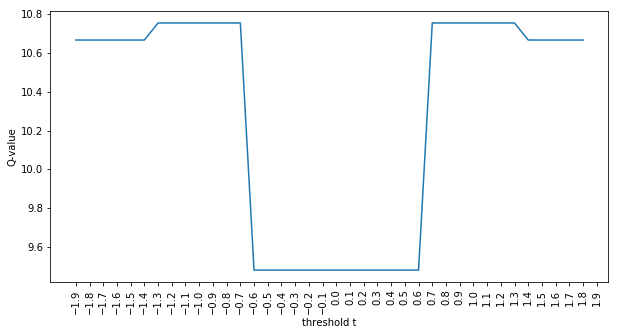

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(-1.9, 1.9, 0.1), Qs)
plt.xticks(np.arange(-1.9, 2.0, 0.1), rotation=90)
plt.ylabel('Q-value')
plt.xlabel('threshold t');

**<font color='red'>Question 1.</font> What is the worst threshold value (to perform a split) according to the variance criterion?**

<font color = 'red'> **Answer options:** </font>
- -1.9
- -1.3
- 0 **[ + ]**
- 1.3
- 1.9 

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q1-5__*

Then let's make splitting in each of the leaves nodes. 
<br> Take your tree with first threshold [$x<0$].
<br> Now add a split in the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. 
<br>It gives us a tree of depth 2 with 7 nodes and 4 leaves. Create a plot of this tree predictions for $x \in [-2, 2]$.

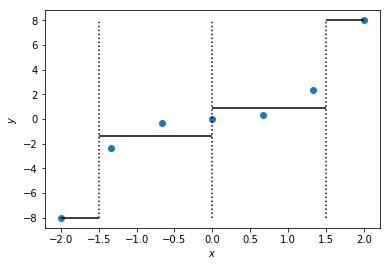

In [13]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.vlines(0, -8, 8, 'k', 'dotted')
plt.vlines(-1.5, -8, 8, 'k', 'dotted')
plt.hlines(np.mean(y[X < -1.5]), -2, -1.5)
plt.hlines(np.mean(y[(X >= -1.5) & (X < 0)]), -1.5, 0)
plt.vlines(1.5, -8, 8, 'k', 'dotted')
plt.hlines(np.mean(y[X >= 1.5]), 1.5, 2)
plt.hlines(np.mean(y[(X < 1.5) & (X >= 0)]), 0, 1.5);

**<font color='red'>Question 2.</font> Tree predictions is a piecewise-constant function, right? How many "pieces" (horizontal segments in the plot that you've just built) are there in the interval [-2, 2]?**

<font color = 'red'> **Answer options:** </font>
- 2
- 4 **[ + ]**
- 6
- 8

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q1-5__*

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option. If you work with Git, then the dataset is already there in `data/mlbootcamp5_train.csv`.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [24]:
df = pd.read_csv('../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [25]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: 
- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$) 
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [26]:
df['age'] = np.floor(df['age'] / 365.25)
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'], drop_first=False)

In [27]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55.0,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51.0,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48.0,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47.0,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [28]:
df.shape

(70000, 16)

In [29]:
y = df['cardio']
X = df.drop('cardio', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=17)
X_train.shape, X_valid.shape

((49000, 15), (21000, 15))

Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz` and Graphviz. Here we need to mention that `sklearn` doesn't draw decision trees on its own, but is able to output a tree in the `.dot` format that can be used by Graphviz for visualization. 

How to plot a decision tree, alternatives:
 1. Install Graphviz and pydotpus yourself (see below)
 2. Use our docker image with all needed packages already installed
 3. Easy way: execute `print(dot_data.getvalue())` with `dot_data` defined below (this can be done without pydotplus and Graphviz), go to http://www.webgraphviz.com, paste the graph code string (digraph Tree {...) and generate a nice picture

There are may be some troubles with graphviz for Windows users.
The error is 'GraphViz's executables not found'.
<br>To fix that - install Graphviz from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).
<br>Then add graphviz path to your system PATH variable. You can do this manually, but don't forget to restart kernel.
<br>Or just run this code:

In [12]:
import os
path_to_graphviz = '' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example) 
os.environ["PATH"] += os.pathsep + path_to_graphviz

Take a look how trees are visualized in the [3rd part](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true) of course materials.

**<font color='red'>Question 3.</font> Which 3 features are used to make predictions in the created decision tree?**

<font color = 'red'> **Answer options:** </font>
- age, ap_lo, chol=1
- age, ap_hi, chol=3 **[ + ]**
- smoke, age, gender
- alco, weight, gluc=3

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q1-5__*

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [30]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [32]:
export_graphviz(tree, 
                out_file="../data/Q3_tree.dot", 
                feature_names=X.columns,
                rounded=True, 
                filled=True)

In [34]:
import graphviz

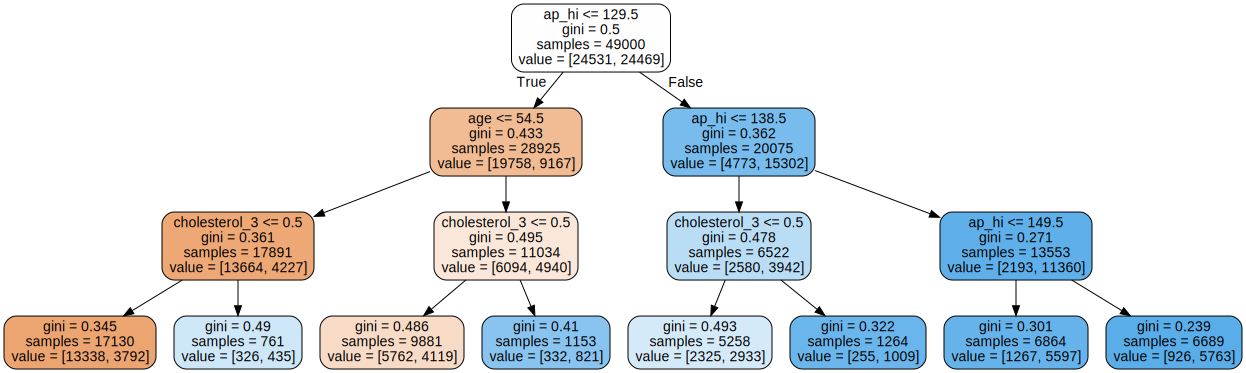

In [35]:
with open("../data/Q3_tree.dot") as f:
    tree_graph = f.read()
graphviz.Source(tree_graph)

In [39]:
tree.score(X_valid, y_valid)

0.7212857142857143

Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [40]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid=tree_params, cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [41]:
tree_grid.best_params_

{'max_depth': 6}

In [49]:
tree_grid.cv_results_['mean_test_score']

array([0.7155102 , 0.72771429, 0.73069388, 0.73114286, 0.73222449,
       0.72997959, 0.73055102, 0.72812245, 0.72630612])

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

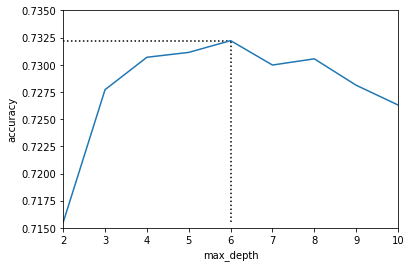

In [73]:
plt.plot(tree_grid.cv_results_['param_max_depth'].data, tree_grid.cv_results_['mean_test_score'])
plt.vlines(tree_grid.cv_results_['param_max_depth'].data[np.argmax(tree_grid.cv_results_['mean_test_score'])], 
           tree_grid.cv_results_['mean_test_score'].min(), tree_grid.cv_results_['mean_test_score'].max(), 
           colors='k', linestyles='dotted')
plt.hlines(tree_grid.cv_results_['mean_test_score'].max(), tree_grid.cv_results_['param_max_depth'].data[0], 
           tree_grid.cv_results_['param_max_depth'].data[np.argmax(tree_grid.cv_results_['mean_test_score'])], 
           colors='k', linestyles='dotted')
plt.axis([2, 10, 0.7150, 0.735])
plt.xlabel('max_depth')
plt.ylabel('accuracy');

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

In [74]:
tree_grid.best_params_

{'max_depth': 6}

In [75]:
tree_grid.score(X_valid, y_valid)

0.7256666666666667

Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

In [90]:
acc1

0.7212857142857143

In [93]:
def GridSearch_effect(original_estimator, best_estimator, X_valid, y_valid):
    acc1 = original_estimator.score(X_valid, y_valid)
    acc2 = best_estimator.score(X_valid, y_valid)
    gseffect = (acc2 - acc1) / acc1 * 100
    print(f'Acc1 = {acc1}')
    print(f'Acc2 = {acc2}')
    print(f'GridSearch effect: {gseffect.round(1)}%')
    return gseffect

In [94]:
GridSearch_effect(tree, tree_grid, X_valid, y_valid)

Acc1 = 0.7212857142857143
Acc2 = 0.7256666666666667
GridSearch effect: 0.6%


0.6073809995378613

**<font color='red'>Question 4.</font> Choose all correct statements.**

<font color = 'red'> **Answer options:** </font>

- There exists a local maximum of accuracy on the built validation curve **[ + ]**
- `GridSearchCV` increased holdout accuracy by **more** than 1%
- There is **no** local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **less** than 1% **[ + ]**

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q1-5__*

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../../img/SCORE2007-eng.png' width=70%>

Let's create new features according to this picture:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. 

<br>Add a ``smoke`` feature.
<br>Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.

**<font color='red'>Question 5.</font> Which binary feature is the most important for heart disease detection (i.e., it is placed in the root of the tree)?**

<font color = 'red'> **Answer options:** </font>

- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3
- Systolic blood pressure from 140 to 160 (mmHg) **[ + ]**
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel #mlcourse_ai_news, pinned thread __#a3_q1-5__*

In [109]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55.0,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51.0,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48.0,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47.0,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


In [130]:
def add_range_features(new_df, orig_df, ranges, orig_feature):
    for fname, frange in ranges.items():
        new_df[fname] = orig_df[orig_feature].isin(frange).astype(int)
    return new_df

In [135]:
new_df = pd.DataFrame()
age_ranges = {'age_[40_50)': range(40, 50), 'age_[50_55)': range(50, 55), 
              'age_[55_60)': range(55, 60), 'age_[60_65)': range(60, 65)}
ap_hi_ranges = {'ap_hi_[120_140)': range(120, 140), 'ap_hi_[140_160)': range(140, 160), 
                'ap_hi_[160_180)': range(160, 180)}
new_df = add_range_features(new_df, df, age_ranges, 'age')
new_df = add_range_features(new_df, df, ap_hi_ranges, 'ap_hi')

In [136]:
new_df[(new_df == 0).all(axis=1)].head()

,age_[40_50),age_[50_55),age_[55_60),age_[60_65),ap_hi_[120_140),ap_hi_[140_160),ap_hi_[160_180)
id,,,,,,,
44,0,0,0,0,0,0,0
142,0,0,0,0,0,0,0
162,0,0,0,0,0,0,0
168,0,0,0,0,0,0,0
566,0,0,0,0,0,0,0


In [137]:
new_df = pd.concat([new_df, df[['cholesterol_1', 'cholesterol_2', 'cholesterol_3']]], axis=1)
new_df.head()

,age_[40_50),age_[50_55),age_[55_60),age_[60_65),ap_hi_[120_140),ap_hi_[140_160),ap_hi_[160_180),cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,
0,0,1,0,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,0,1
2,0,1,0,0,1,0,0,0,0,1
3,1,0,0,0,0,1,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0


In [138]:
new_df['male'] = df['gender'].map({1: 0, 2: 1})
new_df['smoke'] = df['smoke']

In [139]:
new_df.head()

,age_[40_50),age_[50_55),age_[55_60),age_[60_65),ap_hi_[120_140),ap_hi_[140_160),ap_hi_[160_180),cholesterol_1,cholesterol_2,cholesterol_3,male,smoke
id,,,,,,,,,,,,
0,0,1,0,0,0,0,0,1,0,0,1,0
1,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,1,0,0,1,0
4,1,0,0,0,0,0,0,1,0,0,0,0


In [140]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df, y, test_size=0.3)
new_tree = DecisionTreeClassifier(max_depth=3, random_state=17)
new_tree.fit(new_df, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

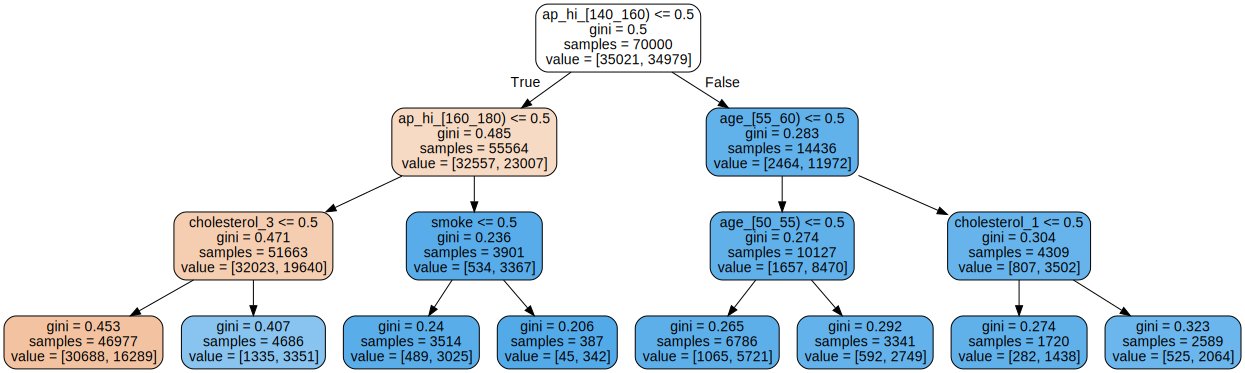

In [141]:
export_graphviz(new_tree, 
                out_file="../data/Q5_tree.dot", 
                feature_names=new_df.columns,
                rounded=True, 
                filled=True)

with open("../data/Q5_tree.dot") as f:
    tree_graph = f.read()
graphviz.Source(tree_graph)